In [1]:
import json, torch
import lightning  as L
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from torch.nn import functional as F
import csv
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
from scipy.interpolate import interp1d
import random

/home/davidteng/anaconda3/envs/wsd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"Using GPU: {torch.cuda.is_available()}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Using GPU: True
cuda:0


#### load training data

In [3]:
train_data_paths = [f"../36_TrainingData/L{loc}_Train.csv" for loc in range(1, 17+1)]
add_ids = [2,4,7,8,9,10,12]
add_train_data_paths = [f"../36_TrainingData_Additional_V2/L{loc}_Train_2.csv" for loc in add_ids]

train_data_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list)))))

for csv_path in train_data_paths:
    with open(csv_path, 'r', encoding='utf-8') as csv_file:
        reader = csv.reader(csv_file)
        header = next(reader)  # 跳過標題列
        for row in reader:
            # 解析數據並存入字典
            loc = row[0]
            date = row[1][:10]
            month = date[5:7]
            day = date[8:10]
            time = row[1][11:16]
            hour = time[:2]
            minute = time[-2:]
            train_data_dict[int(loc)][int(month)][int(day)][int(hour)][int(minute)] = float(row[-1])
for csv_path in add_train_data_paths:
    with open(csv_path, 'r', encoding='utf-8') as csv_file:
        reader = csv.reader(csv_file)
        header = next(reader)  # 跳過標題列
        for row in reader:
            # 解析數據並存入字典
            loc = row[0]
            date = row[1][:10]
            month = date[5:7]
            day = date[8:10]
            time = row[1][11:16]
            hour = time[:2]
            minute = time[-2:]
            train_data_dict[int(loc)][int(month)][int(day)][int(hour)][int(minute)] = float(row[-1])
print((train_data_dict[1][2][2][9][0]))

123.47


#### load cwb data

In [4]:
from collections import defaultdict
import numpy as np
import csv
from scipy.interpolate import interp1d

# 定义月份和特征
months = ['01','02','03','04','05','06','07','08', '09', '10']
features = ['rain', 'raintime', 'solarpower', 'suntime', 'temp', 'uv']

# 初始化 cwb_data_dict，四层嵌套：特征 -> 月份 -> 天数 -> 时间索引
# 时间索引初始为小时（0-23），插值后为分钟（0-1439）
cwb_data_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(float))))

# 读取气象数据
for month in months:
    for feature in features:
        csv_path = f'../cwbdata/{month}/{feature}-{month}.csv'
        try:
            with open(csv_path, 'r', encoding='utf-8') as csv_file:
                reader = csv.reader(csv_file)
                for row in reader:
                    if row[0].isdigit():
                        day = int(row[0])
                        for hour_index, value in enumerate(row[1:], start=0):
                            if hour_index < 24:
                                try:
                                    cwb_data_dict[feature][int(month)][day][hour_index] = float(value)
                                except (ValueError, TypeError):
                                    cwb_data_dict[feature][int(month)][day][hour_index] = None  # 标记为无效值
        except FileNotFoundError:
            print(f"文件未找到: {csv_path}")

# 初始化插值后的数据字典
cwb_data_interp_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))

def interpolate_minute_data(hourly_values):
    """
    对一天的24小时数据进行每分钟插值，返回1440分钟的浮点数列表。
    使用三次样条插值，并确保插值后的值不为负。
    """
    # 已知的分钟位置（每小时的第30分钟）
    known_minutes = np.array([h * 60 + 30 for h in range(24)])
    known_values = np.array(hourly_values)
    
    # 创建所有分钟的索引
    all_minutes = np.arange(1440)
    
    # 处理缺失值后进行插值
    # 使用三次样条插值
    try:
        # 创建插值函数
        spline = interp1d(known_minutes, known_values, kind='cubic', fill_value="extrapolate")
        interpolated = spline(all_minutes)
    except Exception as e:
        print(f"插值失败: {e}")
        interpolated = np.zeros(1440)
    
    # 确保插值后的值不为负
    interpolated = np.clip(interpolated, a_min=0, a_max=None)
    
    return interpolated.tolist()

# 处理每个特征、每个月、每天的数据
for feature in features:
    for month in range(1, 11):  # months '01' to '10' correspond to 1 to 10
        for day in cwb_data_dict[feature][month]:
            # 获取24小时的值
            hourly_values = [cwb_data_dict[feature][month][day].get(hour, None) for hour in range(24)]
            
            # 填充 None 值
            for hour in range(24):
                if hourly_values[hour] is None:
                    # 查找前一个有效值
                    prev = None
                    for h in range(hour - 1, -1, -1):
                        if hourly_values[h] is not None:
                            prev = hourly_values[h]
                            break
                    # 查找后一个有效值
                    next_val = None
                    for h in range(hour + 1, 24):
                        if hourly_values[h] is not None:
                            next_val = hourly_values[h]
                            break
                    # 计算平均值
                    if prev is not None and next_val is not None:
                        hourly_values[hour] = (prev + next_val) / 2
                    elif prev is not None:
                        hourly_values[hour] = prev
                    elif next_val is not None:
                        hourly_values[hour] = next_val
                    else:
                        hourly_values[hour] = 0.0  # 无有效值，填充0.0
            
            # 进行插值
            interpolated_minutes = interpolate_minute_data(hourly_values)
            
            # 将1440分钟的数据分成24个小时，每小时60分钟
            for hour in range(24):
                start_min = hour * 60
                end_min = start_min + 60
                cwb_data_interp_dict[feature][month][day][hour] = interpolated_minutes[start_min:end_min]
                # cwb_data_interp_dict[feature][month][day][hour] = [cwb_data_dict[feature][month][day][hour]] * 60

# 确保插值后的数据没有 None
for feature in features:
    for month in range(1, 11):
        for day in cwb_data_interp_dict[feature][month]:
            for hour in range(24):
                minute_data = cwb_data_interp_dict[feature][month][day][hour]
                if any([x is None for x in minute_data]):
                    # 进一步处理可能的 None（理论上已处理完毕）
                    cwb_data_interp_dict[feature][month][day][hour] = [0.0 if x is None else x for x in minute_data]

# 打印一个示例
print(cwb_data_dict['suntime'][1][2][7])  # 1月1日的1点的rain数据，60个浮点数
print(cwb_data_interp_dict['suntime'][1][2][6])  # 1月1日的1点的rain数据，60个浮点数


0.5
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003978603601497385, 0.008176779249423593, 0.012590805180532846, 0.017216959631579418, 0.022051520839317582, 0.02709076704050163, 0.0323309764718858, 0.03776842737022437, 0.043399397972271665, 0.04922016651478187, 0.055227011234509356, 0.06141621036820833, 0.06778404215263308, 0.07432678482453786, 0.08104071662067698, 0.08792211577780473, 0.09496726053267532, 0.10217242912204308, 0.10953389978266224, 0.11704795075128706, 0.12471086026467185, 0.1325189065595709, 0.14046836787273848, 0.14855552244092884, 0.15677664850089618, 0.16512802428939488, 0.17360592804317926, 0.1822066379990034, 0.19092643239362173]


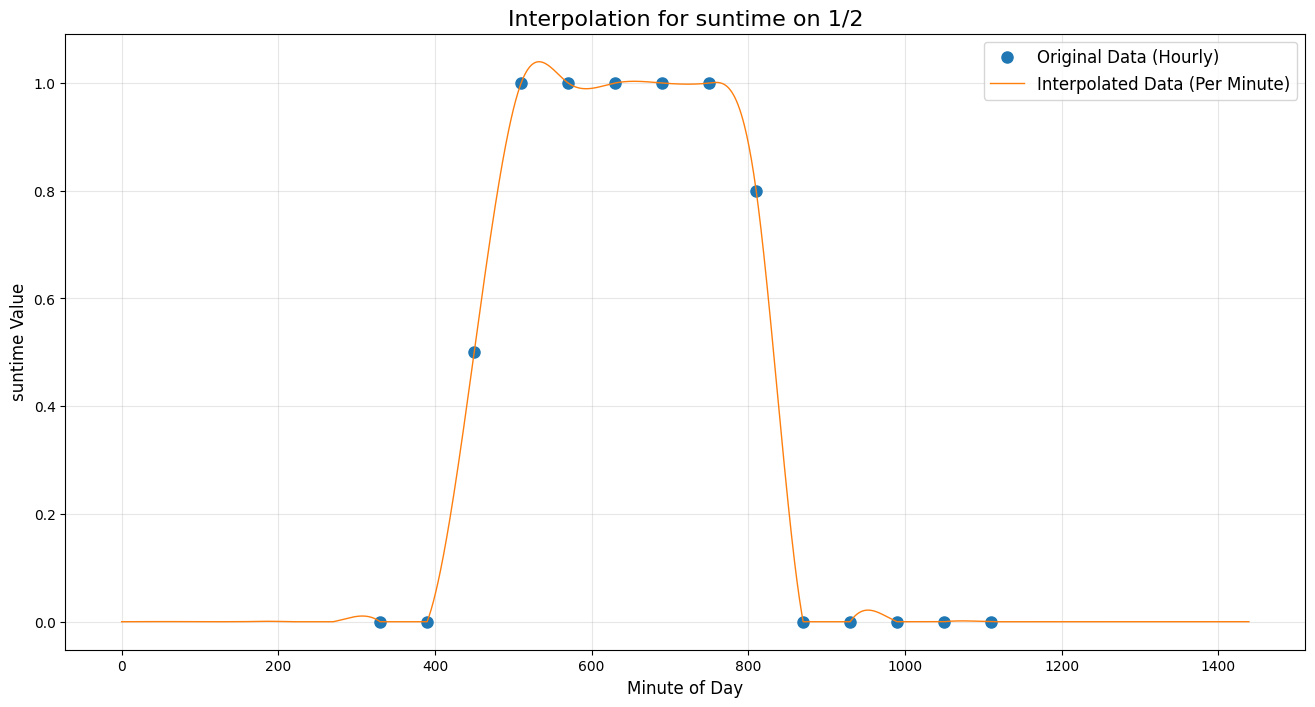

In [5]:
import matplotlib.pyplot as plt

# 选择一个示例日期和特征
sample_feature = 'suntime'  # 特征名称
sample_month = 1         # 月份
sample_day = 2           # 日期

# 获取原始小时值（0:30到23:30的值）
original_hours = [h * 60 + 30 for h in range(24)]
original_values = [cwb_data_dict[sample_feature][sample_month][sample_day].get(h, None) for h in range(24)]

# 获取插值后的分钟值
interpolated_minutes = []
for hour in range(24):
    interpolated_minutes.extend(cwb_data_interp_dict[sample_feature][sample_month][sample_day][hour])

# 创建分钟时间轴
minutes = np.arange(1440)

# 绘制插值结果
plt.figure(figsize=(16, 8))
plt.plot(original_hours, original_values, 'o', label='Original Data (Hourly)', markersize=8)
plt.plot(minutes, interpolated_minutes, '-', label='Interpolated Data (Per Minute)', linewidth=1)
plt.title(f'Interpolation for {sample_feature} on {sample_month}/{sample_day}', fontsize=16)
plt.xlabel('Minute of Day', fontsize=12)
plt.ylabel(f'{sample_feature} Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [6]:
import math

loc_detail = {
    1: {
        'floor': 5,
        'face': {'sin': math.sin(math.radians(181)), 'cos': math.cos(math.radians(181))},
        'coordinate': (23.899444, 121.544444)  # 转换为十进制
    },
    2: {
        'floor': 5,
        'face': {'sin': math.sin(math.radians(175)), 'cos': math.cos(math.radians(175))},
        'coordinate': (23.899444, 121.544722)
    },
    3: {
        'floor': 5,
        'face': {'sin': math.sin(math.radians(180)), 'cos': math.cos(math.radians(180))},
        'coordinate': (23.899722, 121.544722)
    },
    4: {
        'floor': 5,
        'face': {'sin': math.sin(math.radians(161)), 'cos': math.cos(math.radians(161))},
        'coordinate': (23.899444, 121.544444)
    },
    5: {
        'floor': 5,
        'face': {'sin': math.sin(math.radians(208)), 'cos': math.cos(math.radians(208))},
        'coordinate': (23.899444, 121.544722)
    },
    6: {
        'floor': 5,
        'face': {'sin': math.sin(math.radians(208)), 'cos': math.cos(math.radians(208))},
        'coordinate': (23.899444, 121.544444)
    },
    7: {
        'floor': 5,
        'face': {'sin': math.sin(math.radians(172)), 'cos': math.cos(math.radians(172))},
        'coordinate': (23.899444, 121.544444)
    },
    8: {
        'floor': 5,
        'face': {'sin': math.sin(math.radians(219)), 'cos': math.cos(math.radians(219))},
        'coordinate': (23.899722, 121.544722)
    },
    9: {
        'floor': 3,
        'face': {'sin': math.sin(math.radians(151)), 'cos': math.cos(math.radians(151))},
        'coordinate': (23.899444, 121.544444)
    },
    10: {
        'floor': 3,
        'face': {'sin': math.sin(math.radians(223)), 'cos': math.cos(math.radians(223))},
        'coordinate': (23.899444, 121.544444)
    },
    11: {
        'floor': 1,
        'face': {'sin': math.sin(math.radians(131)), 'cos': math.cos(math.radians(131))},
        'coordinate': (23.899722, 121.544722)
    },
    12: {
        'floor': 1,
        'face': {'sin': math.sin(math.radians(298)), 'cos': math.cos(math.radians(298))},
        'coordinate': (23.899722, 121.544722)
    },
    13: {
        'floor': 1,
        'face': {'sin': math.sin(math.radians(249)), 'cos': math.cos(math.radians(249))},
        'coordinate': (23.898889, 121.539444)
    },
    14: {
        'floor': 5,
        'face': {'sin': math.sin(math.radians(197)), 'cos': math.cos(math.radians(197))},
        'coordinate': (23.898889, 121.539444)
    },
    15: {
        'floor': 5,
        'face': {'sin': math.sin(math.radians(127)), 'cos': math.cos(math.radians(127))},
        'coordinate': (24.009167, 121.617222)
    },
    16: {
        'floor': 1,
        'face': {'sin': math.sin(math.radians(82)), 'cos': math.cos(math.radians(82))},
        'coordinate': (24.008889, 121.617222)
    },
    # 17: {
    #     'floor': 1,
    #     'face': None,  # 没有提供具体朝向信息
    #     'coordinate': None  # 自家仓库无具体坐标
    # }
    17: {
        'floor': 1,
        'face': {'sin': math.sin(math.radians(270)), 'cos': math.cos(math.radians(270))},
        'coordinate': (23.955563853486503, 121.59588278748417)
    }
}


#### preprocess data

In [7]:
class Cwb2LocDataset(Dataset):
    def __init__(self, train_data_dict, cwb_data_interp_dict, features, start_time = [6, 30], end_time = [17, 19]):
        self.x = []
        self.y = []

        def extract_features(cwb_data_interp_dict, features, location, month, day, hour, minute):
            try:
                newx = [cwb_data_interp_dict[feature][month][day][hour][minute] for feature in features]
                # newx.append(int(location))  # 添加 location 作为特征
                newx.append(float(loc_detail[location]['floor']))
                newx.append(float(loc_detail[location]['face']['sin']))
                newx.append(float(loc_detail[location]['face']['cos']))
                newx.append(float(loc_detail[location]['coordinate'][0]))
                newx.append(float(loc_detail[location]['coordinate'][1]))
                # newx.append(int(hour))
                # newx.append(int(minute))
            except Exception as e:
                print(f"Error at {location}-{month}-{day} {hour}:{minute}: {e}")
                newx = [0.0] * (len(features) + 1)
            return newx
        def calculate_max_len(start_time, end_time):
            """
            根据 start_time 和 end_time 计算每 10 分钟一组的最大长度 max_len。
            """
            # 计算起始时间和结束时间的总分钟数
            start_minutes = start_time[0] * 60 + start_time[1]
            end_minutes = end_time[0] * 60 + end_time[1]
            
            # 确保时间范围有效
            if end_minutes <= start_minutes:
                raise ValueError("End time must be greater than start time")
            
            # 总分钟数
            total_minutes = end_minutes - start_minutes + 1  # 包含边界的分钟数

            # 计算每 10 分钟为一组的组数
            max_len = total_minutes // 10
            if total_minutes % 10 != 0:
                raise ValueError("The given time range does not align perfectly with 10-minute intervals")
            return max_len

        # start_time = [6, 21]  # 起始时间 6:21
        # end_time = [17, 20]  # 结束时间 17:20
        testdatanum = 0
        brokedatanum = 0
        max_len = calculate_max_len(start_time, end_time)
        for location in train_data_dict:
            for month in train_data_dict[location]:
                for day in train_data_dict[location][month]:
                    train_date_x = []
                    train_date_y = []
                    missing_list = []
                    
                    for hour in range(start_time[0], end_time[0] + 1):
                        minute_start = start_time[1] if hour == start_time[0] else 0
                        minute_end = end_time[1]+1 if hour == end_time[0] else 60

                        for start_minute in range(minute_start, minute_end, 10):  # 每10分钟一组
                            group_x = []
                            group_y = []
                            valid_data_count = 0

                            for minute in range(start_minute, start_minute + 10):
                                if minute >= minute_end:
                                    break
                                # 提取特征数据
                                newx = extract_features(cwb_data_interp_dict, features, location, month, day, hour, minute)
                                # 提取目标数据
                                newy = train_data_dict[location][month][day][hour].get(minute, None)

                                if newy is not None and newy != []:
                                    group_x.append(newx)
                                    group_y.append(newy)
                                    valid_data_count += 1

                            if valid_data_count > 0:
                                # 计算该时间段的平均值
                                averaged_x = np.mean(group_x, axis=0).tolist()
                                train_date_x.append(averaged_x)
                                averaged_y = np.mean(group_y, axis=0).tolist()
                                train_date_y.append([averaged_y])  # 增加一个维度

                            else:
                                # 如果整段时间缺失，抛出错误
                                missing_list.append(f"Missing data for time segment: loc{location} {month}/{day} {hour}:{start_minute}-{start_minute + 9}")
                                pass

                    # 校验时间段长度
                    if len(train_date_x) == max_len:
                        self.x.append(train_date_x)
                        self.y.append(train_date_y)
                    else:
                        if len(train_date_x) >= 55:
                            # print(f"loc{location}_{month}/{day} 数据长度错误: {len(train_date_x)}/{max_len}")
                            # for miss in missing_list:
                            #     print(miss)
                            pass
                        if len(train_date_x) == 15:
                            testdatanum += 1
                        else:
                            brokedatanum += 1
                        # if len(invalid_list) <= 100:
                        #     for inv in invalid_list:
                        #         print(inv)

        print(f'test?: {testdatanum}')
        print(f'broke?: {brokedatanum}')
        
        # 数据检查
        for sample_x in self.x:
            assert len(sample_x) == max_len, f"Sample X length {len(sample_x)} != {max_len}"
        for sample_y in self.y:
            assert len(sample_y) == max_len, f"Sample Y length {len(sample_y)} != {max_len}"
        
        # 转为 NumPy 数组
        self.x = np.array(self.x, dtype=np.float32)
        # self.y = np.array(self.y, dtype=np.float32)
        self.y = np.array(self.y, dtype=np.float32).reshape(-1, max_len, 1)  # 增加一个维度


        # 数据标准化
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()

        # 标准化数据
        self.x_scaler.fit(self.x.reshape(-1, self.x.shape[-1]))
        self.y_scaler.fit(self.y.reshape(-1, self.y.shape[-1]))

        self.x = self.x_scaler.transform(self.x.reshape(-1, self.x.shape[-1])).reshape(self.x.shape)
        self.y = self.y_scaler.transform(self.y.reshape(-1, self.y.shape[-1])).reshape(self.y.shape)


        # 保存标准化器
        with open(f'./scalar_v3_2/x_scaler-{ID}.pkl', 'wb') as f:
            pickle.dump(self.x_scaler, f)
        with open(f'./scalar_v3_2/y_scaler-{ID}.pkl', 'wb') as f:
            pickle.dump(self.y_scaler, f)

    def __getitem__(self, index):
        return torch.tensor(self.x[index], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)


    def __len__(self):
        return len(self.x)


        

In [8]:
# test = Cwb2LocDataset(
#     train_data_dict,
#     cwb_data_interp_dict,
#     features=features
# )
# print((test[1]))

#### cut data

In [9]:
class Cwb2LocDataModule(L.LightningDataModule):
    def __init__(self, train_data_dict, cwb_data_dict, features, batch_size=16, train_split=0.9, start_time = [6, 30], end_time = [17, 19]):
        super().__init__()
        self.train_data_dict = train_data_dict
        self.cwb_data_dict = cwb_data_dict
        self.batch_size = batch_size
        self.train_split = train_split
        self.features = features
        self.start_time = start_time
        self.end_time = end_time

    def setup(self, stage=None):
        dataset = Cwb2LocDataset(self.train_data_dict, self.cwb_data_dict, self.features, self.start_time, self.end_time)
        train_size = int(len(dataset) * self.train_split)
        val_size = len(dataset) - train_size
        
        # # 设置随机种子
        torch.manual_seed(42)  # 确保 PyTorch 随机性可重复
        random.seed(42)        # 确保 Python 随机性可重复
        np.random.seed(42)     # 确保 NumPy 随机性可重复
        
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

In [10]:
# test_datamodule = Cwb2LocDataModule(train_data_dict, cwb_data_interp_dict, features)
# test_datamodule.setup()
# train_loader = test_datamodule.train_dataloader()
# val_loader = test_datamodule.val_dataloader()

# print(f"Train batches: {len(train_loader)}")
# print(f"Validation batches: {len(val_loader)}")

# # 測試加載數據
# for batch in train_loader:
#     x, y = batch
#     print(f"Train batch features shape: {x.shape}")
#     print(f"Train batch labels shape: {y.shape}")
#     break

# for batch in val_loader:
#     x, y = batch
#     print(f"Validation batch features shape: {x.shape}")
#     print(f"Validation batch labels shape: {y.shape}")
#     break

In [11]:
class Cwb2LocModel(L.LightningModule):
    def __init__(self, input_dim=7, hidden_dim=128, num_layers=2, output_dim=1, learning_rate=1e-3, delta=1.0):
        super(Cwb2LocModel, self).__init__()
        self.save_hyperparameters()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.delta = delta  # 動態設置 delta

        # 定義 LSTM 層
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.15, bidirectional=True)

        # 定義全連接層
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim // 4)
        self.fc2 = nn.Linear(hidden_dim // 4, input_dim)
        self.fc3 = nn.Linear(input_dim, 1)

        # 定義損失函數（Huber Loss）
        # self.criterion = nn.HuberLoss(delta=self.delta)
        # self.criterion = nn.MSELoss()
        self.criterion = nn.L1Loss()
        # self.criterion = log_cosh_loss

    def log_cosh_loss(y_pred, y_true):
        loss = torch.mean(torch.log(torch.cosh(y_pred - y_true)))
        return loss

    def forward(self, x):
        # 初始化隱藏狀態和細胞狀態
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(self.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(self.device)
        residual = x
        
        # 前向傳播 LSTM
        out, _ = self.lstm(x, (h0, c0))

        # 通過全連接層得到最終輸出
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out += residual
        out = self.fc3(out)
        
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)  # 使用 Huber Loss
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)  # 使用 Huber Loss
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,  # 初始学习率
            weight_decay=1e-2               # 权重衰减
        )
        
        # 定义调度器
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',             # 目标是最小化验证损失
            factor=0.7,             # 学习率每次调整的倍率
            patience=10,            # 验证损失未改善的 epoch 数
            threshold=1e-4,         # 改善的阈值
            cooldown=5,             # 调整后等待的冷却时间
            min_lr=1e-5,            # 学习率的下限
            verbose=True            # 打印学习率变化信息
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",  # 监控的指标
                "frequency": 1          # 每个 epoch 检查一次
            }
        }
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.9)
        return [optimizer], [scheduler]



In [12]:
batch_size = 16
learning_rate=1e-3
# loc = 2
hidden_dim = 128
lstm_layers = 2
ID = 'g'
data_module = Cwb2LocDataModule(train_data_dict, cwb_data_interp_dict, features, batch_size)
model = Cwb2LocModel(
    input_dim=11,
    hidden_dim=hidden_dim,
    num_layers=lstm_layers,
    output_dim=1,
    learning_rate=learning_rate
)
wandb_name = f'{ID}-f6+5_b{batch_size}_h{hidden_dim}_ll{lstm_layers}_lr{learning_rate}_雙向_mae_p32_3fc_yes插值_yesRELU_dropout0.15_改座標_face315_coord: 23.955563853486503, 121.59588278748417'

# dirpath=f'./saved_models/{loc}/{wandb_name}'
# dirpath=f'./saved_models/{loc}'
dirpath=f'./saved_models_v3_2'

In [13]:
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
logger = WandbLogger(
    project='aicup_power_v3', 
    name=wandb_name,
    save_dir=None,
    offline=False,
    log_model=False,  # 不保存模型
    save_code=False   # 不保存代碼快照
)
callbacks = [
    LearningRateMonitor(),
    ModelCheckpoint(
        monitor='val_loss',
        mode='min',
        auto_insert_metric_name=False,
        dirpath=dirpath,
        filename=f'best-checkpoint-{ID}',
        save_top_k=1,
    ),
    EarlyStopping(
        monitor='val_loss',   # 監控的指標
        patience=50,           # 如果 3 個 epoch 驗證損失沒有改善，則停止訓練
        verbose=True,
        mode='min'            # 損失越小越好
    )
]

In [14]:
trainer = L.Trainer(
    precision=32,
    gradient_clip_val=1.0,
    accumulate_grad_batches=1,
    max_epochs=10000,
    val_check_interval=1.0,
    logger=logger,
    callbacks=callbacks,
    enable_progress_bar=True
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [ ]:
trainer.fit(model, datamodule=data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: david___teng (david___teng-national-central-university). Use `wandb login --relogin` to force relogin


/home/davidteng/anaconda3/envs/wsd/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/davidteng/aicup/electric/code/saved_models_v3_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


test?: 225
broke?: 390


/home/davidteng/anaconda3/envs/wsd/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name      | Type   | Params | Mode 
---------------------------------------------
0 | lstm      | LSTM   | 539 K  | train
1 | fc1       | Linear | 8.2 K  | train
2 | fc2       | Linear | 363    | train
3 | fc3       | Linear | 12     | train
4 | criterion | L1Loss | 0      | train
---------------------------------------------
548 K     Trainable params
0         Non-trainable params
548 K     Total params
2.193     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/davidteng/anaconda3/envs/wsd/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


/home/davidteng/anaconda3/envs/wsd/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 86/86 [00:01<00:00, 51.78it/s, v_num=7urv, train_loss_step=0.327, val_loss=0.352, train_loss_epoch=0.437]

Metric val_loss improved. New best score: 0.352


Epoch 1: 100%|██████████| 86/86 [00:01<00:00, 55.74it/s, v_num=7urv, train_loss_step=0.261, val_loss=0.313, train_loss_epoch=0.324]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.313


Epoch 2: 100%|██████████| 86/86 [00:01<00:00, 60.60it/s, v_num=7urv, train_loss_step=0.253, val_loss=0.297, train_loss_epoch=0.299]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.297


Epoch 3: 100%|██████████| 86/86 [00:01<00:00, 59.93it/s, v_num=7urv, train_loss_step=0.315, val_loss=0.276, train_loss_epoch=0.286]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.276


Epoch 4: 100%|██████████| 86/86 [00:01<00:00, 57.53it/s, v_num=7urv, train_loss_step=0.350, val_loss=0.272, train_loss_epoch=0.271]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.272


Epoch 5: 100%|██████████| 86/86 [00:01<00:00, 57.81it/s, v_num=7urv, train_loss_step=0.363, val_loss=0.256, train_loss_epoch=0.262]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.256


Epoch 7: 100%|██████████| 86/86 [00:01<00:00, 53.77it/s, v_num=7urv, train_loss_step=0.195, val_loss=0.249, train_loss_epoch=0.251]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.249


Epoch 9: 100%|██████████| 86/86 [00:01<00:00, 53.51it/s, v_num=7urv, train_loss_step=0.156, val_loss=0.234, train_loss_epoch=0.242]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.234


Epoch 10: 100%|██████████| 86/86 [00:01<00:00, 54.48it/s, v_num=7urv, train_loss_step=0.236, val_loss=0.233, train_loss_epoch=0.237]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.233


Epoch 12: 100%|██████████| 86/86 [00:01<00:00, 54.40it/s, v_num=7urv, train_loss_step=0.255, val_loss=0.229, train_loss_epoch=0.237]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.229


Epoch 15: 100%|██████████| 86/86 [00:01<00:00, 54.25it/s, v_num=7urv, train_loss_step=0.255, val_loss=0.221, train_loss_epoch=0.224]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.221


Epoch 19: 100%|██████████| 86/86 [00:01<00:00, 54.23it/s, v_num=7urv, train_loss_step=0.258, val_loss=0.217, train_loss_epoch=0.217]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.217


Epoch 24: 100%|██████████| 86/86 [00:01<00:00, 54.88it/s, v_num=7urv, train_loss_step=0.140, val_loss=0.215, train_loss_epoch=0.206]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.215


Epoch 25: 100%|██████████| 86/86 [00:01<00:00, 53.84it/s, v_num=7urv, train_loss_step=0.248, val_loss=0.214, train_loss_epoch=0.205]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.214


Epoch 26: 100%|██████████| 86/86 [00:01<00:00, 54.01it/s, v_num=7urv, train_loss_step=0.209, val_loss=0.213, train_loss_epoch=0.206]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.213


Epoch 29: 100%|██████████| 86/86 [00:01<00:00, 53.93it/s, v_num=7urv, train_loss_step=0.197, val_loss=0.207, train_loss_epoch=0.198]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.207


Epoch 40: 100%|██████████| 86/86 [00:01<00:00, 55.09it/s, v_num=7urv, train_loss_step=0.159, val_loss=0.205, train_loss_epoch=0.180]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.205


Epoch 43: 100%|██████████| 86/86 [00:01<00:00, 54.29it/s, v_num=7urv, train_loss_step=0.203, val_loss=0.204, train_loss_epoch=0.183]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.204


Epoch 45: 100%|██████████| 86/86 [00:01<00:00, 54.74it/s, v_num=7urv, train_loss_step=0.196, val_loss=0.201, train_loss_epoch=0.176] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.201


Epoch 46: 100%|██████████| 86/86 [00:01<00:00, 54.41it/s, v_num=7urv, train_loss_step=0.141, val_loss=0.194, train_loss_epoch=0.173]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.194


Epoch 65: 100%|██████████| 86/86 [00:01<00:00, 54.78it/s, v_num=7urv, train_loss_step=0.163, val_loss=0.192, train_loss_epoch=0.144] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.192


Epoch 73: 100%|██████████| 86/86 [00:01<00:00, 54.02it/s, v_num=7urv, train_loss_step=0.145, val_loss=0.192, train_loss_epoch=0.135] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.192


Epoch 80: 100%|██████████| 86/86 [00:01<00:00, 54.52it/s, v_num=7urv, train_loss_step=0.138, val_loss=0.190, train_loss_epoch=0.130] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.190


Epoch 84: 100%|██████████| 86/86 [00:01<00:00, 53.73it/s, v_num=7urv, train_loss_step=0.114, val_loss=0.190, train_loss_epoch=0.130] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.190


Epoch 86: 100%|██████████| 86/86 [00:01<00:00, 54.39it/s, v_num=7urv, train_loss_step=0.179, val_loss=0.184, train_loss_epoch=0.125] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.184


Epoch 102: 100%|██████████| 86/86 [00:01<00:00, 54.04it/s, v_num=7urv, train_loss_step=0.0962, val_loss=0.183, train_loss_epoch=0.109]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.183


Epoch 112: 100%|██████████| 86/86 [00:01<00:00, 54.90it/s, v_num=7urv, train_loss_step=0.0791, val_loss=0.181, train_loss_epoch=0.104]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.181


Epoch 115: 100%|██████████| 86/86 [00:01<00:00, 54.78it/s, v_num=7urv, train_loss_step=0.0898, val_loss=0.179, train_loss_epoch=0.103]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.179


Epoch 165: 100%|██████████| 86/86 [00:01<00:00, 53.80it/s, v_num=7urv, train_loss_step=0.0617, val_loss=0.182, train_loss_epoch=0.0814]

Monitored metric val_loss did not improve in the last 50 records. Best score: 0.179. Signaling Trainer to stop.


Epoch 165: 100%|██████████| 86/86 [00:01<00:00, 53.60it/s, v_num=7urv, train_loss_step=0.0617, val_loss=0.182, train_loss_epoch=0.0814]


: 